In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
import sys
sys.path.append('./detr/')

In [3]:
!git clone https://github.com/facebookresearch/detr.git   

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 263 (delta 0), reused 1 (delta 0), pack-reused 260
Receiving objects: 100% (263/263), 12.88 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [4]:
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
from sklearn.model_selection import StratifiedKFold

In [6]:
BATCH_SIZE = 8
EPOCHS = 3

In [7]:
train_feats = pd.read_csv("/content/drive/MyDrive/detr/train.csv")

bboxs = np.stack(train_feats['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, col in enumerate(['x', 'y', 'w', 'h']):
    train_feats[col] = bboxs[:,i]
train_feats.drop(columns=['bbox'], inplace=True)

In [8]:
train_feats.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [9]:
folds = 5
seed = 15

strat = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

fold_df = train_feats[['image_id']].copy()
fold_df.loc[:, 'box_count'] = 1
fold_df = fold_df.groupby('image_id').count()
fold_df.loc[:, 'source'] = train_feats[['image_id', 'source']].groupby('image_id').min()['source']
fold_df.loc[:, 'strat_group'] = np.char.add(fold_df['source'].values.astype(str),
                          fold_df['box_count'].apply(lambda x: f'_{x // 15}').values.astype(str))

fold_df.loc[:, 'source'] = train_feats[['image_id', 'source']].groupby('image_id').min()['source']
fold_df.loc[:, 'strat_group'] = np.char.add(fold_df['source'].values.astype(str),
                          fold_df['box_count'].apply(lambda x: f'_{x // 15}').values.astype(str))

fold_df.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(strat.split(X=fold_df.index, y=fold_df['strat_group'])):
    fold_df.loc[fold_df.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [13]:
fold_df.head()

,box_count,source,strat_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,3
005b0d8bb,20,usask_1,usask_1_1,2
006a994f7,25,inrae_1,inrae_1_1,4
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,0


In [24]:
def collate(batch):
    return tuple(zip(*batch))

In [11]:
matcher = HungarianMatcher()
weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']

In [22]:
class WheatData(Dataset):
    def __init__(self,image_ids, dataframe, transforms):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        rows = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread('/content/drive/MyDrive/detr/train/{}.jpg'.format(image_id), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = rows[['x', 'y', 'w', 'h']].values
        labels =  np.zeros(len(boxes), dtype=np.int32)
        
        if self.transforms:
            sample = {'image': image,'bboxes': boxes,'labels': labels}
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
        new_boxes = []
        for box in sample['bboxes']:
            x, y, w, h = box
            xmid = float(x/512)
            ymid = float(y/512)
            width = float(w/512)
            height = float(h/512)
            new_boxes.append([xmid, ymid, width, height])
        boxes = np.array(new_boxes)
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        
        return image, target, image_id

In [14]:
def transforms():
    return A.Compose([A.Resize(height=512, width=512), 
                      ToTensorV2()], 
                     bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

In [15]:
class DETRModel(nn.Module):
    def __init__(self,num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        self.backbone = self.model.backbone
        self.transformer = self.model.transformer
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self, images):
        return self.model(images)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
null_class_coef = 0.5
model = DETRModel(2, 100)
model = model.to(device)


Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

In [17]:
class Counter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.num = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, num, n=1):
        self.num = num
        self.sum += num * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
def train(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    total_loss = Counter()
    for step, (images, targets, image_ids) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{key: val.to(device) for key, val in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[key] * weight_dict[key] for key in loss_dict.keys() if key in weight_dict)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        total_loss.update(losses.item(), BATCH_SIZE)
        
    return total_loss

In [19]:
def valid(data_loader, model, criterion, device):
    model.eval()
    criterion.eval()
    total_loss = Counter()
    with torch.no_grad():
        for step, (images, targets, image_ids) in enumerate(data_loader):   
            images = list(image.to(device) for image in images)
            targets = [{key: val.to(device) for key, val in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[key] * weight_dict[key] for key in loss_dict.keys() if key in weight_dict)
            total_loss.update(losses.item(), BATCH_SIZE)
    
    return total_loss

In [25]:
def run(fold):
    
    df_train = fold_df[fold_df['fold'] != fold]
    df_val = fold_df[fold_df['fold'] == fold]
    
    train_dataset = WheatData(image_ids=df_train.index.values,
                                dataframe=train_feats, transforms=transforms())
    val_dataset = WheatData(image_ids=df_val.index.values, 
                                 dataframe=train_feats, transforms=transforms())
    train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=4, collate_fn=collate)
    val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=4, collate_fn=collate)
    device = torch.device('cuda')
    model = DETRModel(2, 100)
    model = model.to(device)
    criterion = SetCriterion(1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    best_loss = float("inf")
    for epoch in range(EPOCHS):
        train_loss = train(train_data_loader,model,criterion,  optimizer,device, scheduler=None, epoch=epoch)
        val_loss = valid(val_data_loader, model,criterion, device)
        
        print('EPOCH {} ---- TRAINING LOSS {} ---- VALIDATION LOSS {}'.format(epoch+1,round(train_loss.avg, 4),round(val_loss.avg, 4)))
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')
            

In [26]:
run(fold=0)
run(fold=1)
run(fold=2)
run(fold=3)
run(fold=4)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


EPOCH 1 ---- TRAINING LOSS 1.2495 ---- VALIDATION LOSS 0.9741
EPOCH 2 ---- TRAINING LOSS 0.9364 ---- VALIDATION LOSS 0.852
EPOCH 3 ---- TRAINING LOSS 0.9012 ---- VALIDATION LOSS 0.8364


In [32]:
def view_boxes(df, model, device):
    dataset = WheatData(image_ids=df.index.values, dataframe=train_feats,
                                 transforms=transforms())
     
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                                  shuffle=False, num_workers=4, collate_fn=collate)
    
    images, targets, image_ids = next(iter(data_loader))
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    new_boxes= []
    for box_num, box in enumerate(boxes):
        x1, y1, w, h = box
        xmid = x1*512
        ymid = y1*512
        width = w*512
        height = h*512
        new_boxes.append([xmid,ymid,width,height])
    boxes = np.array(new_boxes).astype(np.int32)
    samp = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{key: val.to(cpu_device) for key, val in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(samp, (box[0], box[1]), (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        
    outboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    new_oboxes= []
    for box_num, box in enumerate(outboxes):
        x1, y1, w, h = box
        xmid = x1*512
        ymid = y1*512
        width = w*512
        height = h*512
        new_oboxes.append([xmid,ymid,width,height])
    outboxes = np.array(new_oboxes).astype(np.int32)
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(outboxes,prob):
        if p >0.5:
            cv2.rectangle(samp, (box[0], box[1]), (box[2]+box[0], box[3]+box[1]), (0,0,220), 1)
    
    ax.imshow(samp)

In [26]:
model = DETRModel(num_classes=2, num_queries=100)
model.load_state_dict(torch.load("./detr_best_0.pth"))
view_boxes(fold_df[fold_df['fold'] == 0], model=model, device=torch.device('cuda'))

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


FileNotFoundError: ignored

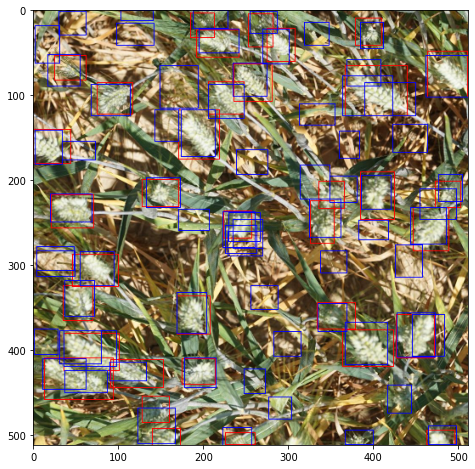

In [37]:
model.load_state_dict(torch.load("./detr_best_1.pth"))
view_boxes(fold_df[fold_df['fold'] == 1],model=model,device=torch.device('cuda'))

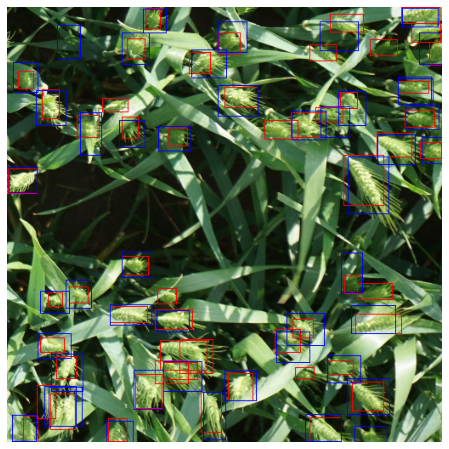

In [103]:
model.load_state_dict(torch.load("./detr_best_2.pth"))
view_boxes(fold_df[fold_df['fold'] == 2],model=model,device=torch.device('cuda'))

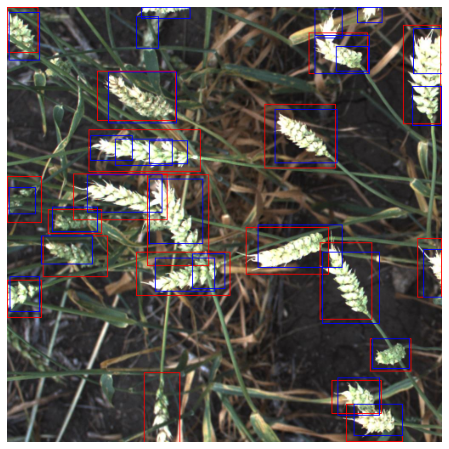

In [104]:
model.load_state_dict(torch.load("./detr_best_3.pth"))
view_boxes(fold_df[fold_df['fold'] == 3],model=model,device=torch.device('cuda'))

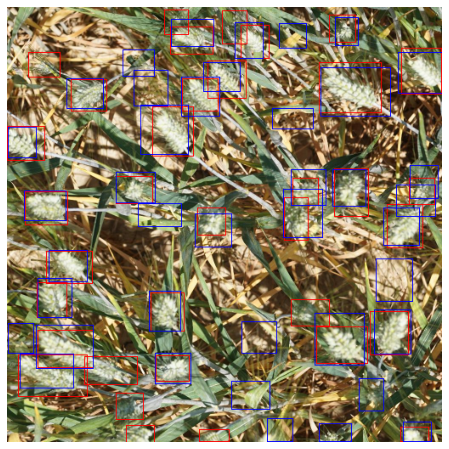

In [105]:
model.load_state_dict(torch.load("./detr_best_4.pth"))
view_boxes(fold_df[fold_df['fold'] == 4],model=model,device=torch.device('cuda'))